In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
pd.options.display.max_rows = 999

In [2]:
prices = 100 + np.cumsum(np.random.normal(size=365*3))

In [3]:
if False:
    with open('prices.npy', 'wb') as f:
        np.save(f, prices)

In [4]:
with open('prices.npy', 'rb') as f:
    prices = np.load(f)

Text(0,0.5,'Price (USD)')

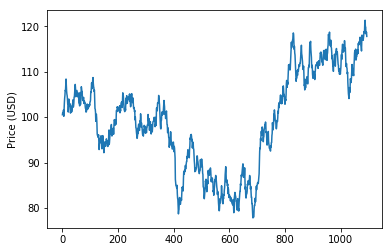

In [5]:
plt.plot(prices)
plt.ylabel('Price (USD)')

In [6]:
class ConditionLatch(object):
    def __init__(self):
        self.last_value = False

    def __call__(self, condition):
        transition = (not self.last_value) and condition
        self.last_value = condition
        return transition


class Ma(object):
    def __init__(self, ma_size):
        self.alpha = 2. / (ma_size + 1)
        self.value = 0

    def __call__(self, p):
        self.value = (1. - self.alpha) * self.value + self.alpha * p
        return self.value


def sim_strategy(prices,
                 ma_slow_size,
                 ma_fast_size,
                 callback=lambda mslow, mfast, capital: None,
                 units_to_trade=100):

    assert ma_slow_size > ma_fast_size

    invested_capital = 0
    max_invested = 0
    profit = 0

    slow, fast = Ma(ma_slow_size), Ma(ma_fast_size)
    buy_condition, sell_condition = ConditionLatch(), ConditionLatch()

    for i, p in enumerate(prices):

        ma_slow = slow(p)
        ma_fast = fast(p)

        if i <= ma_slow_size:  # Don't trade till MAs are fully ready
            callback(ma_slow, ma_fast, 0.)
            continue

        buy_signal = buy_condition(ma_fast > ma_slow)
        sell_signal = sell_condition(ma_fast < ma_slow)
        
        assert not (buy_signal and sell_signal)  # Sanity check

        if i == (len(prices) - 1):
            # Last trade is always a sell, to liqudate the portfolio
            buy_signal = False
            sell_signal = True

        if buy_signal and (not invested_capital):
            invested_capital = p * units_to_trade
            max_invested = max(max_invested, invested_capital)
        elif sell_signal and invested_capital:
            profit += (p * units_to_trade) - invested_capital
            invested_capital = 0

        callback(ma_slow, ma_fast, invested_capital)

    return profit, max_invested

In [7]:
MAX_SLOW = 10

uniform_data = np.full((MAX_SLOW, MAX_SLOW), np.NaN)
columns = ['slow', 'fast', 'profit', 'roi']
d = []

for slow in range(1, MAX_SLOW):
    for fast in range(1, slow):
        profit, max_invested = sim_strategy(prices, slow, fast)
        d.append([slow, fast, profit, 100 * profit / max_invested])

        uniform_data[fast][slow] = profit

df = pd.DataFrame(data=d, columns=columns)
df.sort_values(by='profit', ascending=False)

,slow,fast,profit,roi
2,3,2,5646.235068,47.864757
3,4,1,4983.248719,42.455747
4,4,2,4949.488039,42.168116
0,2,1,4484.832658,37.782872
6,5,1,4413.462995,37.601348
7,5,2,4233.551309,36.068556
10,6,1,4019.543338,34.245273
5,4,3,4016.871478,34.405001
1,3,1,3971.950147,33.462047
8,5,3,3924.467126,33.243228


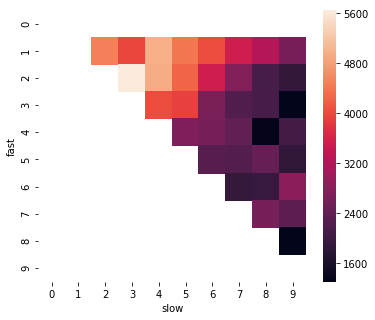

In [8]:
plt.rcParams['figure.figsize'] = [6, 5]
ax = sns.heatmap(uniform_data)

r = ax.set(xlabel='slow', ylabel='fast')

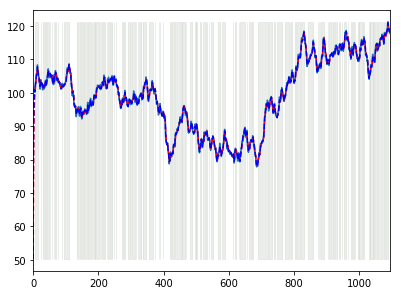

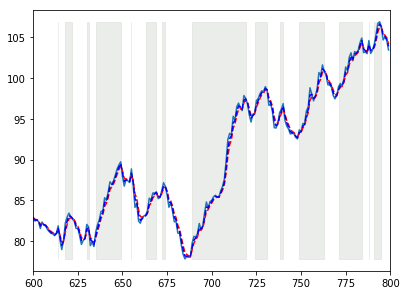

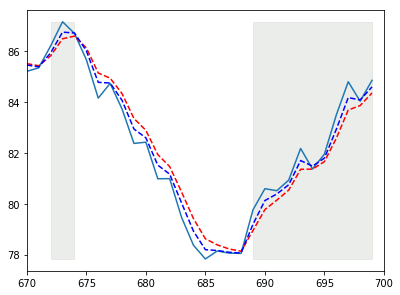

In [9]:
def plot(prices, slow, fast, start=None, srange=None):
    start=0 if start is None else start
    srange=len(prices) if srange is None else srange
    
    mslow, mfast, capital = [], [], []

    def capture(mslow_, mfast_, capital_):
        mslow.append(mslow_)
        mfast.append(mfast_)
        capital.append(capital_)

    sim_strategy(prices, slow, fast, capture)

    capital = np.array(capital)

    prices = prices[start:start + srange]
    mslow = mslow[start:start + srange]
    mfast = mfast[start:start + srange]
    capital = capital[start:start + srange]

    fig, ax = plt.subplots()

    x = list(range(start, start + srange))

    plt.xlim([start, start + srange])

    plt.plot(x, prices)
    plt.plot(x, mslow, 'r--')
    plt.plot(x, mfast, 'b--')

    ax.fill_between(x,
                    np.min([prices, mslow, mfast]),
                    np.max([prices, mslow, mfast]),
                    where=capital > 0,
                    color=sns.xkcd_rgb['light grey'],
                    alpha=0.5)

plt.rcParams['figure.figsize'] = [14, 6]
plt.rcParams['figure.figsize'] = [6.4, 4.8]

plot(prices, 3, 2)  # , 200, 500)

plot(prices, 3, 2, 600, 200)

plot(prices, 3, 2, 670, 30)

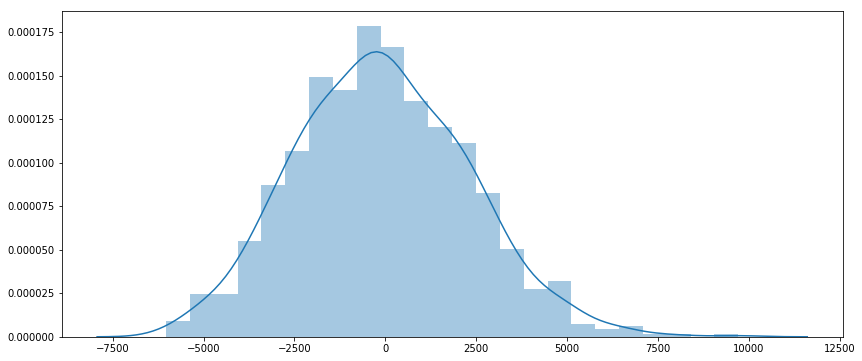

In [10]:
plt.rcParams['figure.figsize'] = [14, 6]

total_profit = []
for i in range(1000):
    t_prices = 100 + np.cumsum(np.random.normal(size=365*3))
    profit, max_invested = sim_strategy(t_prices, 3, 2)
    total_profit.append(profit)

ax = sns.distplot(total_profit)

In [11]:
from sklearn.model_selection import train_test_split

def train_and_test(prices, segments, random_state=5):
    segment_size = prices.shape[0] // segments

    X = (prices[:(segment_size * segments)]
         .reshape(segments, segment_size))

    X_train, X_test = train_test_split(X,
                                       test_size=0.20,
                                       random_state=random_state)

    def average_profit(slow, fast, sequences):
        return (sum(sim_strategy(p, slow, fast)[0] for p in sequences)
                / sequences.shape[0])

    # Train
    MAX_SLOW = 10
    performance = [(slow, fast, average_profit(slow, fast, X_train))
                   for slow in range(1, MAX_SLOW)
                   for fast in range(1, slow)]

    best = sorted(performance, key=lambda row: -row[2])[0]

    # Evaluate
    slow, fast, p0 = best

    profits = [sim_strategy(subseq, slow, fast)[0]
               for subseq in X_test]
    sns.distplot(profits)

    return best, profits

((2, 1, 125.86939637292008), -3.525631036089635)

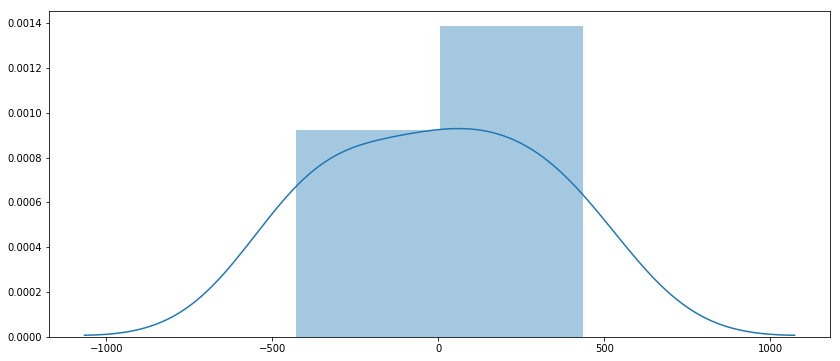

In [12]:
best, profits = train_and_test(prices, segments=50)
best, np.average(profits)

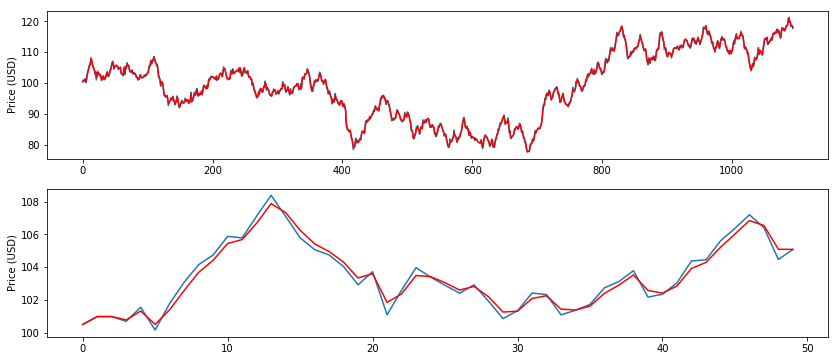

In [13]:
prices_with_pattern = np.copy(prices)

ac = 0.3
for i, p in enumerate(prices_with_pattern):
    if i > 1:
        prices_with_pattern[i] = (ac * prices_with_pattern[i - 1] +
                                  (1 - ac) * prices_with_pattern[i])

f, ax = plt.subplots(2)

ax[0].plot(prices)
ax[0].plot(prices_with_pattern, 'r')
ax[0].set_ylabel('Price (USD)')

ax[1].plot(prices[:50])
ax[1].plot(prices_with_pattern[:50], 'r')
ax[1].set_ylabel('Price (USD)')

None

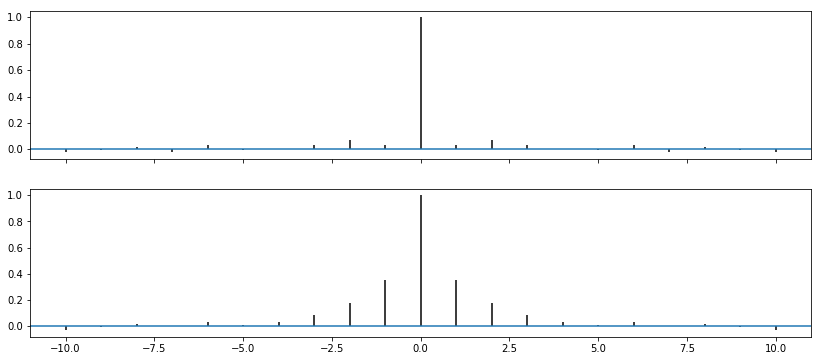

In [14]:
f, ax = plt.subplots(2, sharex=True)
ax[0].acorr([i - j for i, j in zip(prices, prices[1:])])
ax[1].acorr([i - j for i, j in zip(prices_with_pattern, prices_with_pattern[1:])])
None

((2, 1, 234.66832986912974), 117.06263687998862)

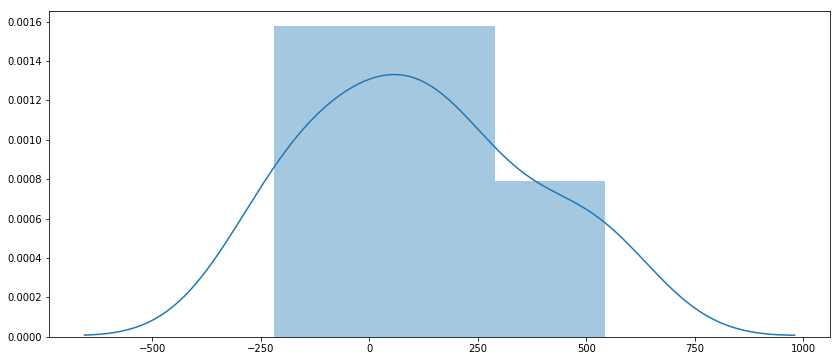

In [15]:
best, profits = train_and_test(prices_with_pattern, segments=50)
best, np.average(profits)

In [16]:
a , b = sim_strategy(prices_with_pattern, 2, 1)
(100 * a) / b

107.4293729497689